In [1]:
%reset -f

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from scipy.linalg import null_space

# Generate Feature Matrix

In [3]:
def generate_feature_matrix(nrows,ncols,condition_no,orthogonality_flag):
    '''
    This generates the feature matrix for the problem.
    Note that our problem deals with overparametrized regime, i.e. no of cols>= no of rows
    
    nrows: Number of rows of the matrix
    ncols: Number of columns of the matrix.(ncols>nrows by assumption)
    condition_no: Condition number of the matrix.
    Eigenvalues are generated geometrically between 1 and 1/condition_no
    '''
    
    if orthogonality_flag==False:

        U = ortho_group.rvs(nrows)
        V = ortho_group.rvs(ncols)
        V = V[:,0:nrows]

        exp = (1/(nrows-1))*np.arange(0,nrows,1)

        Sigma = np.diag((1/condition_no)**exp)

        A = U@Sigma@V.T
    
    else:
        A = ortho_group.rvs(ncols)
        A = A[0:nrows]
    
    return A

# Gradient descent for rPGD

$L = \frac{1}{2}||y-Agw||^2$ s.t. $||w||=1$

Gradients:

$\nabla_g L = -w^TA^Ty+gw^TA^TAw$

$\nabla_w L = g^2 A^T A w - g y^T A$

Update equations:
$v_{t+1} = w_t-\eta_t\nabla_w L$

$w_{t+1} = \frac{v_{t+1}}{||v_{t+1}||}$

$g_{t+1} = g_t-\gamma_t\nabla_g L$

In [4]:
def rPGD_cost(w,g,A,y):
    y_pred = g*(A@w)
    f = 0.5*np.linalg.norm(y-y_pred)**2
    return f

In [5]:
def rPGD_grad_wrt_g_w(w,g,A,y):
    grad_w = -g*(y.T@A)+g*g*(A.T@A@w)
    grad_g = -((A@w).T)@y+g*np.linalg.norm(A@w)**2
    return grad_w, grad_g

In [6]:
def rPGD_update(w_t,g_t,A,y,eta_t,gamma_t):
    grad_w, grad_g = rPGD_grad_wrt_g_w(w_t,g_t,A,y)
    v_t = w_t-eta_t*grad_w
    
    w_new = v_t/np.linalg.norm(v_t)
    
    g_new = g_t-gamma_t*grad_g
    
    return w_new, g_new

In [7]:
def run_rPGD(w_init, g_init, A, y, T, eta_t, gamma_t, tol, mode):
    
    if T==None:
        T = 50000
        
    if tol==None:
        tol = 1e-10
        
    err = rPGD_cost(w_init,g_init,A,y)
    
    w_t = w_init
    g_t = g_init
    
    time_idx = 0
    
    g_list = []
    w_list = []
    err_list = []
    
    # If step size is constant or a specified array
    if mode=='standard':
        if isinstance(eta_t,float)==True:
            eta_i = eta_t*np.ones(T)
        
        if isinstance(gamma_t,float)==True:
            gamma_i = gamma_t*np.ones(T)
    
        while(time_idx<T and err>tol):

            w_new, g_new = rPGD_update(w_t,g_t,A,y,eta_i[time_idx],gamma_i[time_idx])

            err = rPGD_cost(w_new,g_new,A,y)

            w_t = w_new
            g_t = g_new

            err_list.append(err)
            g_list.append(g_new)
            w_list.append(w_new)

            time_idx+=1
    
    if mode=='step_size_is_func':
        while(time_idx<T and err>tol):
            
            eta_i = eta_t(w_t,g_t,A,time_idx)
            gamma_i = gamma_t(w_t,g_t,A,time_idx)

            w_new, g_new = rPGD_update(w_t,g_t,A,y,eta_i,gamma_i)

            err = rPGD_cost(w_new,g_new,A,y)

            w_t = w_new
            g_t = g_new

            err_list.append(err)
            g_list.append(g_new)
            w_list.append(w_new)

            time_idx+=1
        
    
    return w_new, g_new, g_list, err_list, w_list

# Vanilla GD

$ L = \frac{1}{2}||y-Aw||^2$

Gradients for g and w:

$\nabla_w L = A^T A w- A^T w$

Update:

$w_{t+1} = w_t-\mu_t\nabla_w L$

In [8]:
def vanilla_GD_cost(x,A,y):
    y_pred = A@x
    f = 0.5*np.linalg.norm(y-y_pred)**2
    return f

In [9]:
def vanilla_grad(x,A,y):
    grad_x = (A.T@A)@x-A.T@y
    return grad_x

In [10]:
def vanilla_GD_update(x_t,A,y,mu_t):
    grad_x = vanilla_grad(x_t,A,y)
    x_new = x_t-mu_t*grad_x
    
    return x_new

In [11]:
def run_vanilla_GD(w_init, g_init, A, y, T, mu_t, tol):
    
    if T==None:
        T = 50000
        
    if isinstance(mu_t,float)==True:
        mu_i = mu_t*np.ones(T)
    
    if tol==None:
        tol = 1e-10
        
    err = rPGD_cost(w_init,g_init,A,y)
    
    x_t = g_init*w_init
    
    time_idx = 0
    
    g_list = []
    err_list = []
    
    while(time_idx<T and err>tol):
        
        x_new = vanilla_GD_update(x_t,A,y,mu_i[time_idx])
        
        err = vanilla_GD_cost(x_new,A,y)
        
        x_t = x_new
        g_new = np.linalg.norm(x_new)
        
        err_list.append(err)
        g_list.append(g_new)
        
        time_idx+=1
    
    w_new = x_new/np.linalg.norm(x_new)
    g_new = np.linalg.norm(x_new)
    
    return w_new, g_new, g_list, err_list

# WN

$ L = \frac{1}{2}||y-\frac{Agw}{||w||}||^2$

Replace $\frac{gw}{||w||}$ with $x$

$L = \frac{1}{2}||y-Ax||^2$

Gradients for g and w:

$\nabla_g L = \frac{(\nabla_x L)^Tw}{||w||}$

$\nabla_w L = \frac{g}{||w||} M_x \nabla_x L$ with $M_x = 1-\frac{x x^T}{||x||^2}$

$\nabla_x L = A^T A x- A^T y$

Updates:

$w_{t+1} = w_t-\eta_t\nabla_w L$

$g_{t+1} = g_t-\gamma_t\nabla_g L$

In [12]:
def wn_cost(w,g,A,y):
    y_pred = (g/np.linalg.norm(w))*(A@w)
    f = 0.5*np.linalg.norm(y-y_pred)**2
    return f

In [13]:
def wn_grad_wrt_g_w(w,g,A,y):
    
    x = (g/np.linalg.norm(w))*w
    
    grad_x = (A.T@A)@x-A.T@y
    if np.linalg.norm(x)!=0:
        M_x = np.eye(d)-(np.outer(x,x))/(np.linalg.norm(x))**2
    else:
        M_x = np.eye(d)
    
    grad_g = (grad_x.T@w)/np.linalg.norm(w)
    grad_w = (g/np.linalg.norm(w))*(M_x@grad_x)
    
    return grad_w, grad_g

In [14]:
def wn_update(w_t,g_t,A,y,eta_t,gamma_t):
    grad_w, grad_g = wn_grad_wrt_g_w(w_t,g_t,A,y)
    
    w_new = w_t-eta_t*grad_w
    g_new = g_t-gamma_t*grad_g
    
    return w_new, g_new

In [15]:
def run_wn(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode):
    
    if T==None:
        T = 50000
    
    if tol==None:
        tol = 1e-10
        
    err = wn_cost(w_init,g_init,A,y)
    
    w_t = w_init
    g_t = g_init
    
    time_idx = 0
    
    g_list = []
    err_list = []
    w_list = []
    
    # If step size is constant or a specified array
    if mode=='standard':
        if isinstance(eta_t,float)==True:
            eta_i = eta_t*np.ones(T)
        
        if isinstance(gamma_t,float)==True:
            gamma_i = gamma_t*np.ones(T)
    
        while(time_idx<T and err>tol):

            w_new, g_new = wn_update(w_t,g_t,A,y,eta_i[time_idx],gamma_i[time_idx])

            err = wn_cost(w_new,g_new,A,y)

            w_t = w_new
            g_t = g_new

            err_list.append(err)
            g_list.append(g_new)
            w_list.append(w_new)

            time_idx+=1
    
    if mode=='step_size_is_func':
        while(time_idx<T and err>tol):
            eta_i = eta_t(w_t,g_t,A,time_idx)
            gamma_i = gamma_t(w_t,g_t,A,time_idx)
        
            
            w_new, g_new = wn_update(w_t,g_t,A,y,eta_i,gamma_i)

            err = wn_cost(w_new,g_new,A,y)

            w_t = w_new
            g_t = g_new

            err_list.append(err)
            g_list.append(g_new)
            w_list.append(w_new)

            time_idx+=1
        
    
    return w_new, g_new, g_list, err_list, w_list

# Code for initialisation and feature matrix extraction

In [16]:
m = 20
d = 100

condition_number = 1

noise_std = 0.0

A = generate_feature_matrix(m,d,condition_number,False)

w_o = A.T@np.random.randn(m)
w_o = w_o/np.linalg.norm(w_o)

g_o = 3

y = g_o*A@w_o+noise_std*np.random.randn(m)

# Figure 1 in paper

Comparison of norms of output for small stepsize(equal for all algorithms). The norm of the intial guess is varied. The norm of the actual w is kept at 3.

In [17]:
w_init = np.random.randn(d)
w_init = w_init/np.linalg.norm(w_init)

g_init_list = [0,1,2,3,4]
g_est_array = np.zeros((3,len(g_init_list))) # 3 rows for 3 algorithms

T = None
eta_t = 0.005
gamma_t = 0.005
mu_t = 0.005

tol = 1e-5
mode='standard'

for i in range(len(g_init_list)):
    g_init = g_init_list[i]
    w_new, g_new, g_list, err_list, w_list = run_rPGD(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    g_est_array[0,i] = g_new
    
    w_new, g_new, g_list, err_list, w_list = run_wn(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    g_est_array[1,i] = g_new
    
    w_new, g_new, g_list, err_list = run_vanilla_GD(w_init, g_init, A, y, T, mu_t, tol)
    g_est_array[2,i] = g_new


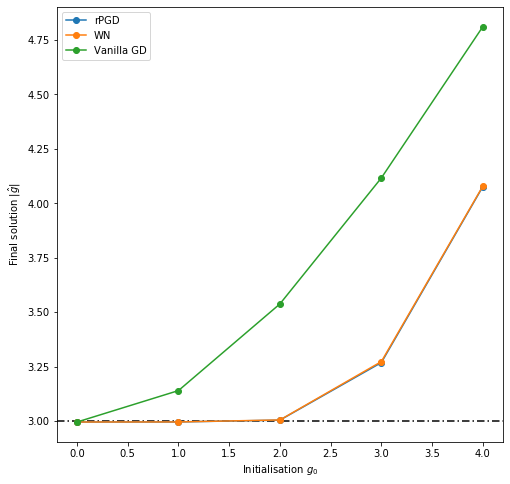

In [18]:
plt.figure(figsize=(8,8))
plt.axhline(y=3,dashes=(5, 2, 1, 2),c='k')
plt.plot(g_init_list,np.abs(g_est_array[0]),ls='solid',marker='o',label='rPGD')
plt.plot(g_init_list,np.abs(g_est_array[1]),ls='solid',marker='o',label='WN')
plt.plot(g_init_list,np.abs(g_est_array[2]),ls='solid',marker='o',label='Vanilla GD')
plt.xlabel('Initialisation '+r'$g_0$')
plt.ylabel('Final solution '+r'$|\hat{g}|$')
plt.legend()
plt.show()

# Figure 3 top plot in paper

Comparison of norms of output for relatively large stepsizes(equal for all algorithms). The norm of the intial guess is varied. The norm of the actual w is kept at 3.

In [19]:
w_init = np.random.randn(d)
w_init = w_init/np.linalg.norm(w_init)

g_init_list = np.arange(0,4.5,0.5)
g_est_array = np.zeros((3,len(g_init_list))) # 3 rows for 3 algorithms

T = None
eta_t = 0.1
gamma_t = 0.1
mu_t = 0.1

tol = 1e-5
mode='standard'

for i in range(len(g_init_list)):
    g_init = g_init_list[i]
    w_new, g_new, g_list, err_list, w_list = run_rPGD(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    g_est_array[0,i] = g_new
    
    w_new, g_new, g_list, err_list, w_list = run_wn(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    g_est_array[1,i] = g_new
    
    w_new, g_new, g_list, err_list = run_vanilla_GD(w_init, g_init, A, y, T, mu_t, tol)
    g_est_array[2,i] = g_new

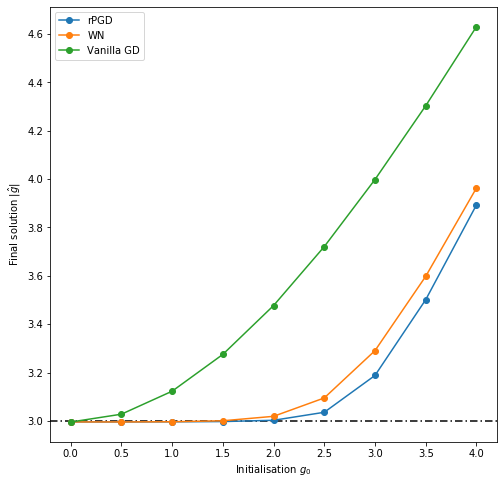

In [20]:
plt.figure(figsize=(8,8))
plt.axhline(y=3,dashes=(5, 2, 1, 2),c='k')
plt.plot(g_init_list,np.abs(g_est_array[0]),ls='solid',marker='o',label='rPGD')
plt.plot(g_init_list,np.abs(g_est_array[1]),ls='solid',marker='o',label='WN')
plt.plot(g_init_list,np.abs(g_est_array[2]),ls='solid',marker='o',label='Vanilla GD')
plt.xlabel('Initialisation '+r'$g_0$')
plt.ylabel('Final solution '+r'$|\hat{g}|$')
plt.legend()
plt.show()

# Figure 3 bottom plot in paper

Comparison of norms of output. A two phase algorithm is implemented for rPGD and WN algorithms, with the weight vector updated at optimal rate, while g is updated slowly. Vanilla GD is implemented at small learning rates. The norm of initial guess is varied in steps of 0.5, with the actual norm kept at 3.

In [21]:
w_init = np.random.randn(d)
w_init = w_init/np.linalg.norm(w_init)

g_init_list = [0.01,0.5,1,1.5,2,2.5,3,3.5,4]
g_est_array = np.zeros((3,len(g_init_list))) # 3 rows for 3 algorithms

T = None

eta_t_wn = lambda w_t,g_t,A,time_idx: np.linalg.norm(w_t)/(g_t**2)
gamma_t_wn = lambda w_t,g_t,A,time_idx: 0.005
eta_t_rpgd = lambda w_t,g_t,A,time_idx: 1/(g_t**2)
gamma_t_rpgd = lambda w_t,g_t,A,time_idx: 0.005
mu_t = 0.005

tol = 1e-5
mode='step_size_is_func'

for i in range(len(g_init_list)):
    g_init = g_init_list[i]
    w_new, g_new, g_list, err_list, w_list = run_rPGD(w_init, g_init, A, y, T, eta_t_rpgd, gamma_t_rpgd, tol,mode)
    g_est_array[0,i] = g_new
    
    w_new, g_new, g_list, err_list, w_list = run_wn(w_init, g_init, A, y, T, eta_t_wn, gamma_t_wn, tol,mode)
    g_est_array[1,i] = g_new
    
    w_new, g_new, g_list, err_list = run_vanilla_GD(w_init, g_init, A, y, T, mu_t, tol)
    g_est_array[2,i] = g_new

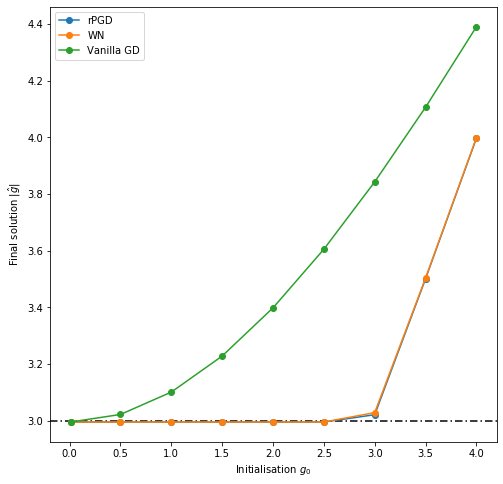

In [22]:
plt.figure(figsize=(8,8))
plt.axhline(y=3,dashes=(5, 2, 1, 2),c='k')
plt.plot(g_init_list,np.abs(g_est_array[0]),ls='solid',marker='o',label='rPGD')
plt.plot(g_init_list,np.abs(g_est_array[1]),ls='solid',marker='o',label='WN')
plt.plot(g_init_list,np.abs(g_est_array[2]),ls='solid',marker='o',label='Vanilla GD')
plt.xlabel('Initialisation '+r'$g_0$')
plt.ylabel('Final solution '+r'$|\hat{g}|$')
plt.legend()
plt.show()

# Plot for dynamics of null space projections

According to the continuous flow perspective, we expect the trajectories of rPGD and WN to be very close for small step sizes.

Solving the differential equation for WN in continuous time gives us the following relation for null space projection.

$w_t^\perp = w_o^\perp e^{\frac{g_o^2-g_t^2}{2c}}$

We compare empirical and theoretical figures for the same.

In [23]:
def extract_null_space_component(A,x):
    P = A.T@A
    x_perp = (np.eye(len(P))-P)@x
    return x_perp

In [24]:
w_init = np.random.randn(d)
w_init = w_init/np.linalg.norm(w_init)

g_init = 2.8
T = None
c = 2
eta_t = 0.005
gamma_t = c*eta_t
mu_t = 0.005

tol = 1e-10
mode='standard'

w_new, g_new, g_list_rpgd, err_list, w_list_rpgd = run_rPGD(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    
w_new, g_new, g_list_wn, err_list, w_list_wn = run_wn(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    
w_new, g_new, g_list, err_list = run_vanilla_GD(w_init, g_init, A, y, T, mu_t, tol)

In [25]:
w_perp_init = extract_null_space_component(A,w_init)
#RPGD

lhs_rpgd = []
rhs_rpgd = []

for i in range(len(w_list_rpgd)):
    w_perp = extract_null_space_component(A,w_list_rpgd[i]) 
    lhs_rpgd.append(np.log(np.linalg.norm(w_perp)/np.linalg.norm(w_perp_init)))
    rhs_rpgd.append((g_init**2-g_list_rpgd[i]**2)/(2*c))
    
#WN

lhs_wn = []
rhs_wn = []

for i in range(len(w_list_wn)):
    w_perp = extract_null_space_component(A,w_list_wn[i])
    lhs_wn.append(np.log(np.linalg.norm(w_perp)/np.linalg.norm(w_perp_init)))
    rhs_wn.append((g_init**2-g_list_wn[i]**2)/(2*c))

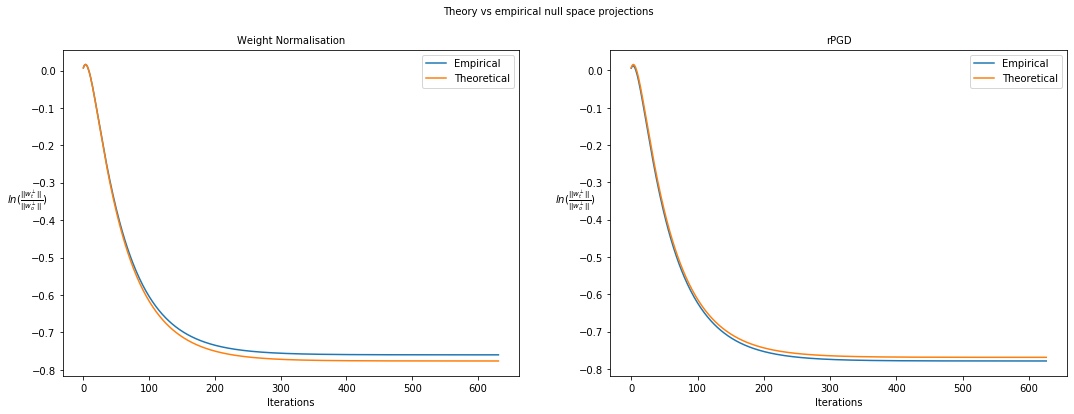

In [26]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(np.arange(0,len(lhs_wn),1),lhs_wn,label='Empirical')
ax[0].plot(np.arange(0,len(lhs_wn),1),np.array(rhs_wn),label='Theoretical')
ax[0].set_xlabel('Iterations',size=10)
ax[0].set_ylabel(r'$ln(\frac{||w_t^\perp||}{||w_o^\perp||})$',rotation=0,size=10)
ax[0].legend()
ax[0].set_title('Weight Normalisation',size=10)

ax[1].plot(np.arange(0,len(lhs_rpgd),1),lhs_rpgd,label='Empirical')
ax[1].plot(np.arange(0,len(lhs_rpgd),1),np.array(rhs_rpgd),label='Theoretical')
ax[1].set_xlabel('Iterations',size=10)
ax[1].set_ylabel(r'$ln(\frac{||w_t^\perp||}{||w_o^\perp||})$',rotation=0,size=10)
ax[1].legend()
ax[1].set_title('rPGD',size=10)

plt.suptitle('Theory vs empirical null space projections',size=10)
plt.show()

# Figure 4 top plot in paper

Condition no is varied from 1 to 100, while initialisation is kept fixed. Also, all step sizes are equal to 0.01 throughout

In [27]:
condition_no_list = [1,10,100]

g_init = 2.8
g_est_array = np.zeros((3,len(condition_no_list))) # 3 rows for 3 algorithms
w_init = np.random.randn(d)
w_init = w_init/np.linalg.norm(w_init)


T = 20000
eta_t = 0.01
gamma_t = 0.01
mu_t = 0.01

tol = 1e-5
mode='standard'

for i in range(len(condition_no_list)):
    
    m = 20
    d = 100

    noise_std = 0.0

    A = generate_feature_matrix(m,d,condition_no_list[i],False)

    w_o = A.T@np.random.randn(m)
    w_o = w_o/np.linalg.norm(w_o)

    g_o = 3

    y = g_o*A@w_o+noise_std*np.random.randn(m)
    
    w_new, g_new, g_list, err_list, w_list = run_rPGD(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    g_est_array[0,i] = g_new
    
    w_new, g_new, g_list, err_list, w_list = run_wn(w_init, g_init, A, y, T, eta_t, gamma_t, tol,mode)
    g_est_array[1,i] = g_new
    
    w_new, g_new, g_list, err_list = run_vanilla_GD(w_init, g_init, A, y, T, mu_t, tol)
    g_est_array[2,i] = g_new

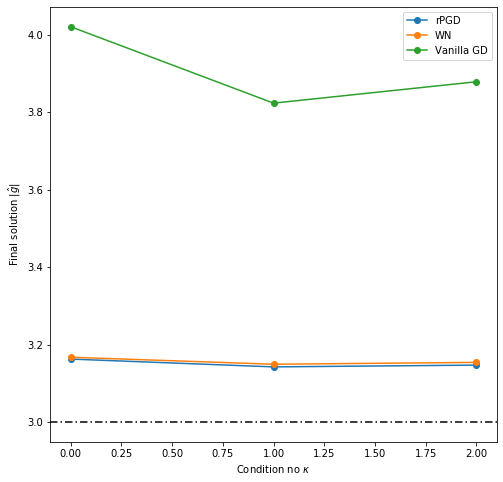

In [28]:
plt.figure(figsize=(8,8))
plt.axhline(y=3,dashes=(5, 2, 1, 2),c='k')
plt.plot(np.log10(condition_no_list),np.abs(g_est_array[0]),ls='solid',marker='o',label='rPGD')
plt.plot(np.log10(condition_no_list),np.abs(g_est_array[1]),ls='solid',marker='o',label='WN')
plt.plot(np.log10(condition_no_list),np.abs(g_est_array[2]),ls='solid',marker='o',label='Vanilla GD')
plt.xlabel('Condition no '+r'$\kappa$')
plt.ylabel('Final solution '+r'$|\hat{g}|$')
plt.legend()
plt.show()

# Figure 4 bottom plot in paper

In [29]:
condition_no_list = [1,10,100]

g_init = 2.8
g_est_array = np.zeros((3,len(condition_no_list))) # 3 rows for 3 algorithms
w_init = np.random.randn(d)
w_init = w_init/np.linalg.norm(w_init)


T = 20000
eta_t_wn = lambda w_t,g_t,A,time_idx: 0.1
gamma_t_wn = lambda w_t,g_t,A,time_idx: 0.1*(time_idx>=5000)
eta_t_rpgd = lambda w_t,g_t,A,time_idx: 0.1
gamma_t_rpgd = lambda w_t,g_t,A,time_idx: 0.1*(time_idx>=5000)

mu_t = 1.0

tol = 1e-8
mode='step_size_is_func'

for i in range(len(condition_no_list)):
    
    m = 20
    d = 100

    noise_std = 0.0

    A = generate_feature_matrix(m,d,condition_no_list[i],False)

    w_o = A.T@np.random.randn(m)
    w_o = w_o/np.linalg.norm(w_o)

    g_o = 3

    y = g_o*A@w_o+noise_std*np.random.randn(m)
    
    w_new, g_new, g_list, err_list, w_list = run_rPGD(w_init, g_init, A, y, T, eta_t_rpgd, gamma_t_rpgd, tol,mode)
    g_est_array[0,i] = g_new
    
    w_new, g_new, g_list, err_list, w_list = run_wn(w_init, g_init, A, y, T, eta_t_wn, gamma_t_wn, tol,mode)
    g_est_array[1,i] = g_new
    
    w_new, g_new, g_list, err_list = run_vanilla_GD(w_init, g_init, A, y, T, mu_t, tol)
    g_est_array[2,i] = g_new

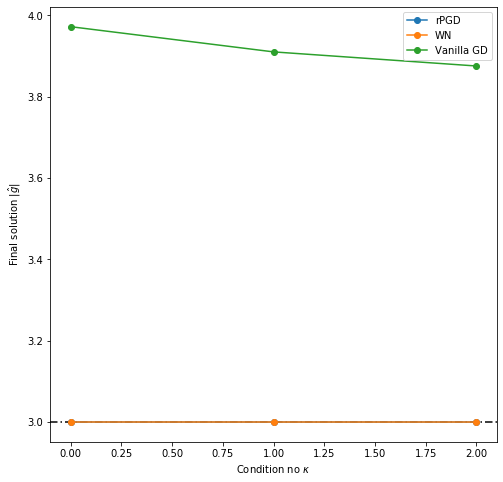

In [30]:
plt.figure(figsize=(8,8))
plt.axhline(y=3,dashes=(5, 2, 1, 2),c='k')
plt.plot(np.log10(condition_no_list),np.abs(g_est_array[0]),ls='solid',marker='o',label='rPGD')
plt.plot(np.log10(condition_no_list),np.abs(g_est_array[1]),ls='solid',marker='o',label='WN')
plt.plot(np.log10(condition_no_list),np.abs(g_est_array[2]),ls='solid',marker='o',label='Vanilla GD')
plt.xlabel('Condition no '+r'$\kappa$')
plt.ylabel('Final solution '+r'$|\hat{g}|$')
plt.legend()
plt.show()

# Peeking into the dynamics of the two phase algorithm

We take a closer look at what happens emprirically when the two phase algorithm is implemented. This is done for both rPGD and WN.

Results:

In the first phase, the optimiser tries to get the alignment of $w$ close to $w*$. In the next phase, the scaling(magnitude) is adjusted so as to achieve the minimum loss. 

The result is that we get a minimum norm solution that is valid for a large range of condition numbers of feature matrix.

In [31]:
m = 20
d = 100

condition_number = 1

noise_std = 0.0

A = generate_feature_matrix(m,d,condition_number,False)

w_o = A.T@np.random.randn(m)
w_o = w_o/np.linalg.norm(w_o)

g_o = 3

y = g_o*A@w_o+noise_std*np.random.randn(m)

In [32]:
w_init = np.random.randn(d)
w_init = w_init/np.linalg.norm(w_init)

g_init = 2.8

T = 20000

eta_t_wn = lambda w_t,g_t,A,time_idx: 0.1
gamma_t_wn = lambda w_t,g_t,A,time_idx: 0.1*(time_idx>=5000)
eta_t_rpgd = lambda w_t,g_t,A,time_idx: 0.1
gamma_t_rpgd = lambda w_t,g_t,A,time_idx: 0.1*(time_idx>=5000)

tol = 1e-8
mode='step_size_is_func'

w_new, g_new, g_list_rpgd, err_list_rpgd, w_list_rpgd = run_rPGD(w_init, g_init, A, y, T, eta_t_rpgd, gamma_t_rpgd, tol,mode)
w_new, g_new, g_list_wn, err_list_wn, w_list_wn = run_wn(w_init, g_init, A, y, T, eta_t_wn, gamma_t_wn, tol,mode)

In [33]:
# RPGD
err_w_rpgd = []
err_g_rpgd = []

for i in range(len(w_list_rpgd)):
    err_w_rpgd.append(np.linalg.norm(w_o-(np.sign(g_list_rpgd[i])*w_list_rpgd[i]/np.linalg.norm(w_list_rpgd[i]))))
    err_g_rpgd.append(np.abs(g_o-np.abs(g_list_rpgd[i])))
    
# WN
err_w_wn = []
err_g_wn = []

for i in range(len(w_list_wn)):
    err_w_wn.append(np.linalg.norm(w_o-(np.sign(g_list_rpgd[i])*w_list_wn[i]/np.linalg.norm(w_list_wn[i]))))
    err_g_wn.append(np.abs(g_o-np.abs(g_list_wn[i])))

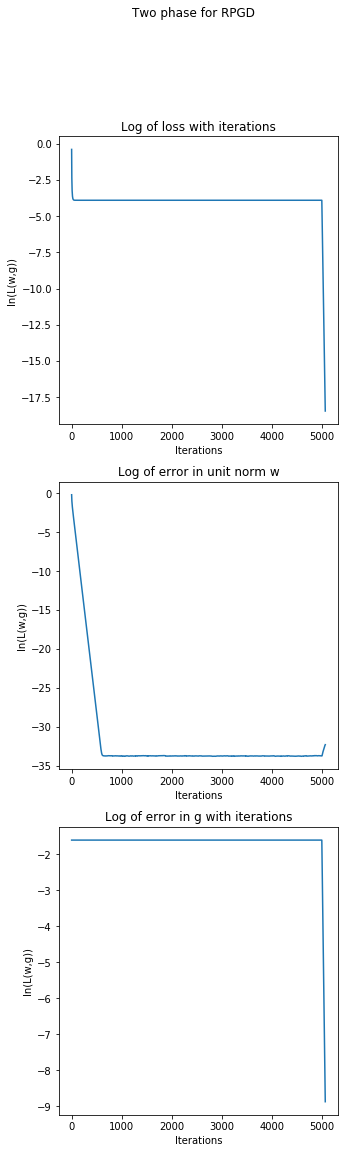

In [34]:
#RPGD
fig, ax = plt.subplots(3,1,figsize=(5,18))

ax[0].plot(np.log(err_list_rpgd))
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('ln(L(w,g))')
ax[0].set_title('Log of loss with iterations')

ax[1].plot(np.log(err_w_rpgd))
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('ln(L(w,g))')
ax[1].set_title('Log of error in unit norm w')

ax[2].plot(np.log(err_g_rpgd))
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('ln(L(w,g))')
ax[2].set_title('Log of error in g with iterations')

plt.suptitle('Two phase for RPGD')
plt.show()

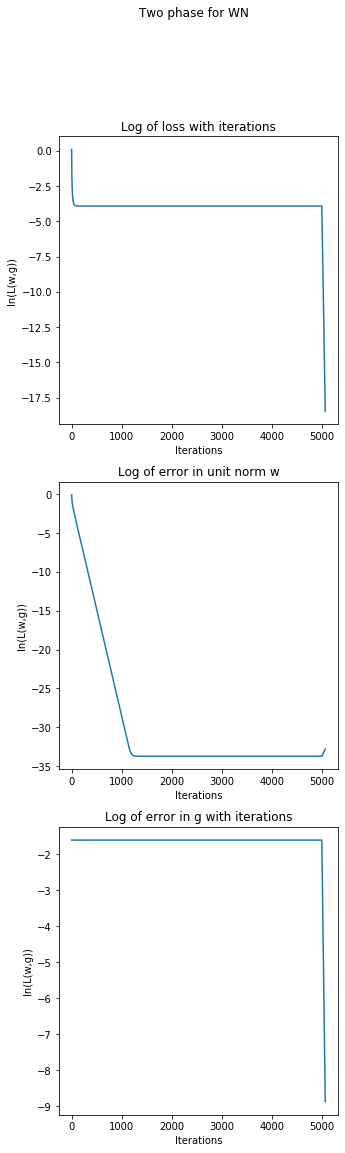

In [35]:
#WN

fig, ax = plt.subplots(3,1,figsize=(5,18))

ax[0].plot(np.log(err_list_wn))
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('ln(L(w,g))')
ax[0].set_title('Log of loss with iterations')

ax[1].plot(np.log(err_w_wn))
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('ln(L(w,g))')
ax[1].set_title('Log of error in unit norm w')

ax[2].plot(np.log(err_g_wn))
ax[2].set_xlabel('Iterations')
ax[2].set_ylabel('ln(L(w,g))')
ax[2].set_title('Log of error in g with iterations')

plt.suptitle('Two phase for WN')
plt.show()